In [26]:
import pandas as pd
import os
import csv
from datetime import datetime
import numpy as np
import sys
import matplotlib.pyplot as plt

In [19]:
# read cases data
cases = pd.read_csv('us-counties-4-26.csv')
mobility = pd.read_csv('DL-us-mobility-daterow-4-23.csv')

#connect fips and cases/ in a dictionary so it becomes (fips,cases) key-value pair
cases_dict = {}
deaths_dict = {}
mobility_dict = {}
fips_to_name = {}

cases = cases[pd.notnull(cases['fips'])]
mobility = mobility[pd.notnull(mobility['fips'])]

cases['fips'] = cases['fips'].apply(lambda x: 0 if np.isnan(x) else int(x))
mobility['fips'] = mobility['fips'].apply(lambda x: 0 if np.isnan(x) else int(x))


# Beacuse cases here represent the accumulative cases in that county , and the date is sorted, so we only
# need to record the number of cases on the last day which stands for the total confirmed cases before 4-26

for index, row in cases.iterrows():
    key = str(row['fips'])
    deaths_dict[key] = int(row['deaths']) 
    cases_dict[key] = int(row['cases'])
    if key not in fips_to_name:
        fips_to_name[key] = row['county']
    
# we need to sum up the distance people traveled according to the fips 
for index, row in mobility.iterrows():
    key = str(row['fips'])
    if key in mobility_dict:
        mobility_dict[key] += row['m50']
    else:
        mobility_dict[key] = row['m50']
    if key not in fips_to_name:
        fips_to_name[key] = row['admin2']
    
# Now we compute m50/cases which represents the every p distance we travel, there will be one more confirmed case
m50_cases_dict = {}
m50_deaths_dict = {}
for item in cases_dict:
    if item in mobility_dict:
        m50_cases_dict[item] = mobility_dict[item]/cases_dict[item]
        if int(deaths_dict[item]) == 0:
            m50_deaths_dict[item] = 0
        else:
            m50_deaths_dict[item] = mobility_dict[item]/deaths_dict[item]

# Sort by distance/cases

# for item in sorted(m50_cases_dict, key=m50_cases_dict.get, reverse=True):
#     print("%s,%s"%(fips_to_name[item],m50_cases_dict[item]))

# we write the result into a csv file
with open('result.csv', 'w',encoding='utf-8') as f:
    f.write("county_name,distance\n")
    for key in m50_cases_dict.keys():
        county_name = fips_to_name[key]
        f.write("%s,%s\n"%(county_name,m50_cases_dict[key]))

In [21]:
# we can see how distance distribute among counties
res = pd.read_csv('result.csv')
res['distance'].describe()

count     2554.000000
mean        50.708342
std        248.071232
min          0.002478
25%          2.110413
50%         10.777292
75%         41.605350
max      11057.744000
Name: distance, dtype: float64

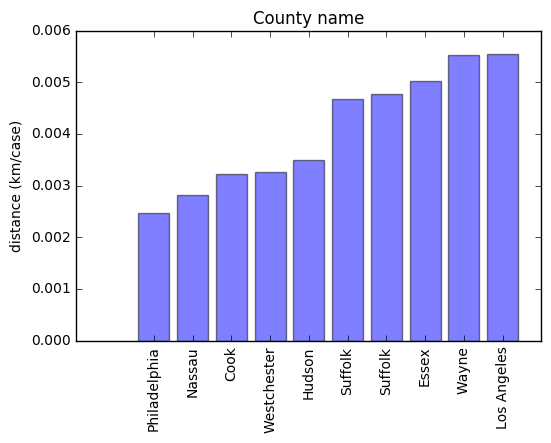

In [39]:
county_list = []
distance_list = []

for item in sorted(m50_cases_dict, key=m50_cases_dict.get):
    county_list.append(fips_to_name[item])
    distance_list.append(m50_cases_dict[item])

# let's see first 20 counties that has minimum distance(km/cases)
y_pos = np.arange(len(distance_list[0:10]))
plt.bar(y_pos, distance_list[0:10], align='center', alpha=0.5)
plt.xticks(y_pos, county_list[0:10],rotation=90)
plt.ylabel('distance (km/case)')
plt.title('County name')

plt.show()

In [72]:
# We can view the distance we calculated as a symbol which represents how dangerous a county is.
# eg, the distance of county M is p km/case, which means every p km people in M travel, there will
# be one more confirmed case, so, the samller of the distance, more dangerour will be to travel a 
# lot in that county.
# 
# Let's take a closer view at some specific county to see how this distance changes with time going
# by, as we can tell, at first the distance should be large since there is only few confirmed cases.
# We will take Los Angeles for example

# the fips number for Los Angeles county is 6037
# print(fips_to_name["6037"])
LA_cases = {}
LA_mobility = {}
cur_dist = 0
mobility_per_day = {}

# we use date as key here, and make (date,cases) key-value pairs
for index, row in cases.iterrows():
    key = str(row['fips'])
    if key == "6037":
        LA_cases[row['date']] = int(row['cases'])

# we make (date,mobility) key-value pairs
for index, row in mobility.iterrows():
    key = str(row['fips'])
    if key == "6037":
        cur_dist += row['m50']
        LA_mobility[row['date']] = cur_dist
        mobility_per_day[row['date']] = row['m50']

date_list = []
distance_per_case = []
cases_list = []
travel_list = []
travel_sum_list = []
for item in LA_mobility:
    if item in LA_cases:
        date_list.append(item)

date_list.sort()

for i in range(len(date_list)):
    date = date_list[i]
    cases_list.append(LA_cases[date])
    travel_list.append(mobility_per_day[date])
    travel_sum_list.append(LA_mobility[date])
    distance_per_case.append(LA_mobility[date]/LA_cases[date])

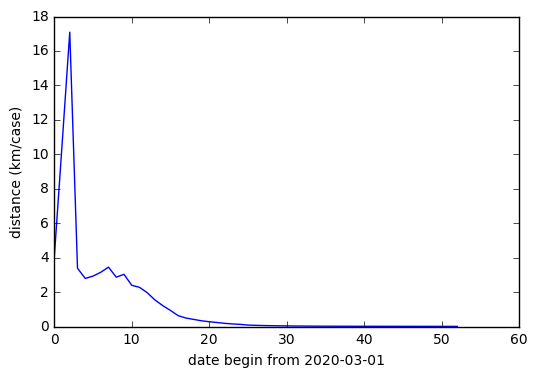

In [66]:
plt.plot(range(len(date_list)),distance_per_case)
plt.ylabel("distance (km/case)")
plt.xlabel("date begin from "+date_list[0])
plt.show()

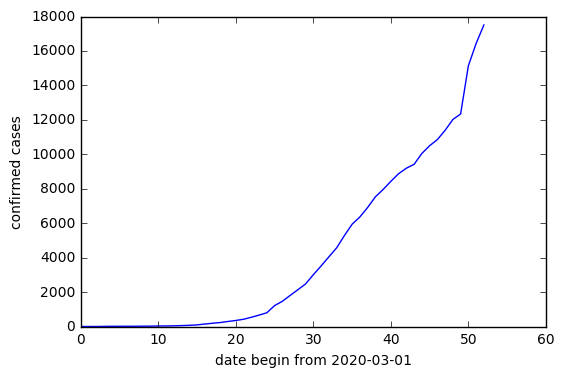

In [67]:
plt.plot(range(len(date_list)),cases_list)
plt.ylabel("confirmed cases")
plt.xlabel("date begin from "+date_list[0])
plt.show()

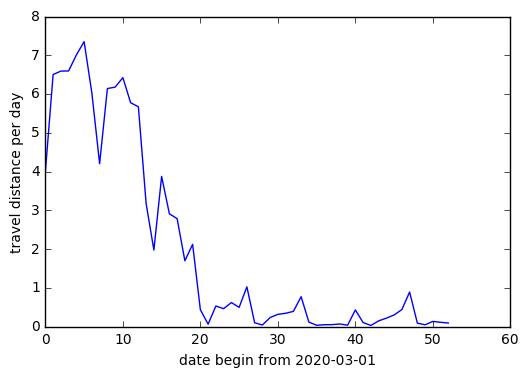

In [76]:
plt.plot(range(len(date_list)),travel_list)
plt.ylabel("travel distance per day")
plt.xlabel("date begin from "+date_list[0])
plt.show()

# As we can see here, even if people moves a small distance, LA becomes more and more dangerours, why is that?
# We think it has something to do with the lack of mobility date and only few people get tested at first, we can
# see there is only one confirmed case from 1/26 to 3/3 in LA, but it's only because people are not get tested, so
# we should also add distance people traveled during that time for calculation.